![Animal Crossing: New Horizons official art](images/AnimalCrossingNewHorizons.jpg)
*Source: [Nintendo Life](https://nintendosoup.com/animal-crossing-new-horizons-full-official-artwork-revealed/)*

# Predicting Sentiment of Animal Crossing: New Horizons Reviews

## Introduction

This project consists of two parts: the creation of a machine learning model using the [scikit-learn](https://scikit-learn.org/stable/) library that can perform an optimized sentiment rating on reviews for Animal Crossing: New Horizons and the deployment of that model to create an application that can predict the sentiment of a raw user-submitted review for the game.

## Business Problem

Animal Crossing: New Horizons is one of the Nintendo Switch's best entries, having sold 33.89 million copies [(as of June 30, 2021)](https://www.nintendo.co.jp/ir/en/finance/software/index.html) and is the second-best selling game in the console's history. Having released during the beginning the COVID-19 pandemic, it served as a cultural icon and played a major part in driving Switch sales. However, since the beginning it has been a growing topic of controversy and debate. Fans of the franchise would (and still do) comment about how lackluster its features were compared to past titles, while others just become burnt out and bored quickly due to the lack of content.

If I were given the task to help Nintendo's development team figure out new updates for New Horizons or help contribute ideas for the next title in the Animal Crossing series, I would want to look at reviews and feedback surrounding New Horizons to let them know what they did well and what they could improve on. To do this, we can create and test a machine learning model using the scikit-learn library that can accurately predict the sentiment of user's review based its content. We can then use the best model and create an application where users can input their own reviews for the game to collect and sort different reviews for New Horizons. This way, we can use the feedback collected from the users who submitted reviews to further investigate what we did well and what we can improve on with later titles. The feedback we receive can also help with marketing strategies to promote this game and other future Switch titles.

## Data Preparation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize, regexp_tokenize, FreqDist
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from nltk.collocations import *
from nltk.util import ngrams
import string
import re

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import plot_confusion_matrix, recall_score, f1_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline

import warnings
warnings.filterwarnings('ignore')

import pickle

### Exploring the data

The data used comes from Jesse Mostipak on [Kaggle](https://www.kaggle.com/jessemostipak/animal-crossing) and contains several datasets pertaining to Animal Crossing: New Horizons; specifically, we'll be looking at the dataset with  reviews from Metacritic users that submitted reviews for the game between March 2020 and May 2020, which is accessed through the `user_reviews.csv` file.

In [2]:
user_df = pd.read_csv('data/user_reviews.csv')
user_df.head()

,grade,user_name,text,date
0,4,mds27272,My gf started playing before me. No option to ...,2020-03-20
1,5,lolo2178,"While the game itself is great, really relaxin...",2020-03-20
2,0,Roachant,My wife and I were looking forward to playing ...,2020-03-20
3,0,Houndf,We need equal values and opportunities for all...,2020-03-20
4,0,ProfessorFox,BEWARE! If you have multiple people in your h...,2020-03-20


Dropping the `user_name` column of the dataframe so we can more easily focus on the most important components,
we investigate the properties of the data:

In [3]:
user_df = user_df.drop(['user_name'], axis=1)
print(user_df.info())
user_df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2999 entries, 0 to 2998
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   grade   2999 non-null   int64 
 1   text    2999 non-null   object
 2   date    2999 non-null   object
dtypes: int64(1), object(2)
memory usage: 70.4+ KB
None


,grade,text,date
0,4,My gf started playing before me. No option to ...,2020-03-20
1,5,"While the game itself is great, really relaxin...",2020-03-20
2,0,My wife and I were looking forward to playing ...,2020-03-20
3,0,We need equal values and opportunities for all...,2020-03-20
4,0,BEWARE! If you have multiple people in your h...,2020-03-20
...,...,...,...
2994,1,1 Island for console limitation.I cannot play ...,2020-05-03
2995,1,"Per giocare con figli o fidanzate, mogli o per...",2020-05-03
2996,0,One island per console is a pathetic limitatio...,2020-05-03
2997,2,Even though it seems like a great game with ma...,2020-05-03


Looking at a distribution of scores that the users gave the game within the this time period, it seems that the reviews were heavily polarized; a majority of users seemed to either love or hate the game.

<AxesSubplot:>

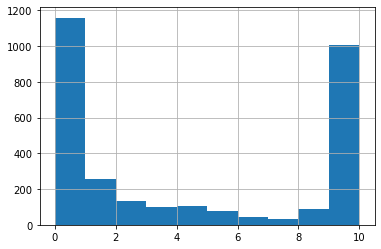

In [4]:
user_df['grade'].hist()

### Tokenization with NLTK

Before we continue with exploring our data, we tokenize our text data so each review is split into lists of individual words instead of whole strings; one thing we can do after tokenizing our text is to make and look at frequency distributions to observe which words were the most common among all our text data. To tokenize our text, we use functions found in [NLTK](https://www.nltk.org/), a Python library dedicated for language processing and analysis. 

We define a regular expression pattern before applying the tokenizer to our text so that it can recognize contractions as one word instead of splitting them by the root word and the apostrophes.

In [5]:
pattern = "([a-zA-Z]+(?:'[a-z]+)?)"

user_df['tokens_raw'] = [regexp_tokenize(text, pattern) for text in user_df['text']]

user_df['tokens_raw']

0       [My, gf, started, playing, before, me, No, opt...
1       [While, the, game, itself, is, great, really, ...
2       [My, wife, and, I, were, looking, forward, to,...
3       [We, need, equal, values, and, opportunities, ...
4       [BEWARE, If, you, have, multiple, people, in, ...
                              ...                        
2994    [Island, for, console, limitation, I, cannot, ...
2995    [Per, giocare, con, figli, o, fidanzate, mogli...
2996    [One, island, per, console, is, a, pathetic, l...
2997    [Even, though, it, seems, like, a, great, game...
2998    [Game, is, fantastic, Nintendo, deciding, that...
Name: tokens_raw, Length: 2999, dtype: object

For NLTK to recognize all cases of the word as the same word, we also change all the words to lowercase.

In [6]:
user_df['tokens'] = user_df['tokens_raw'].apply(lambda x: [word.lower() for word in x])
user_df.head()

,grade,text,date,tokens_raw,tokens
0,4,My gf started playing before me. No option to ...,2020-03-20,"[My, gf, started, playing, before, me, No, opt...","[my, gf, started, playing, before, me, no, opt..."
1,5,"While the game itself is great, really relaxin...",2020-03-20,"[While, the, game, itself, is, great, really, ...","[while, the, game, itself, is, great, really, ..."
2,0,My wife and I were looking forward to playing ...,2020-03-20,"[My, wife, and, I, were, looking, forward, to,...","[my, wife, and, i, were, looking, forward, to,..."
3,0,We need equal values and opportunities for all...,2020-03-20,"[We, need, equal, values, and, opportunities, ...","[we, need, equal, values, and, opportunities, ..."
4,0,BEWARE! If you have multiple people in your h...,2020-03-20,"[BEWARE, If, you, have, multiple, people, in, ...","[beware, if, you, have, multiple, people, in, ..."


Finally to clean our review text and to ensure we obtain a meaningful observation of the most common words, we remove stopwords from our reviews. These stopwords are based on the following crireria:
- Common stopwords in the English language found in NLTK's `stopwords.words('english')`
- Punctuation
- Other words that are redundant and irrelevant to our analysis of review sentiment; this would include general words like "game" and the title of the game
- Standalone letters that remain in each review by themselves after tokenizing each review with the regular expression

In [7]:
stopwords_list = stopwords.words('english')
stopwords_list += list(string.punctuation)
stopwords_list += ['game', 'animal', 'crossing', 'new', 'horizons', 'horizon']
stopwords_list += list(string.ascii_lowercase)
user_df['no_stops'] = user_df['tokens'].apply(lambda x: [w for w in x if w not in stopwords_list])

user_df.head()

,grade,text,date,tokens_raw,tokens,no_stops
0,4,My gf started playing before me. No option to ...,2020-03-20,"[My, gf, started, playing, before, me, No, opt...","[my, gf, started, playing, before, me, no, opt...","[gf, started, playing, option, create, island,..."
1,5,"While the game itself is great, really relaxin...",2020-03-20,"[While, the, game, itself, is, great, really, ...","[while, the, game, itself, is, great, really, ...","[great, really, relaxing, gorgeous, can't, ign..."
2,0,My wife and I were looking forward to playing ...,2020-03-20,"[My, wife, and, I, were, looking, forward, to,...","[my, wife, and, i, were, looking, forward, to,...","[wife, looking, forward, playing, released, bo..."
3,0,We need equal values and opportunities for all...,2020-03-20,"[We, need, equal, values, and, opportunities, ...","[we, need, equal, values, and, opportunities, ...","[need, equal, values, opportunities, players, ..."
4,0,BEWARE! If you have multiple people in your h...,2020-03-20,"[BEWARE, If, you, have, multiple, people, in, ...","[beware, if, you, have, multiple, people, in, ...","[beware, multiple, people, house, want, play, ..."


With our text tokenized and cleaned, we can create a frequency distribution of all the words in our review text to find which words were the most common among all our reviews. 

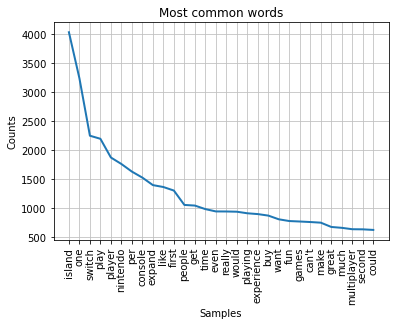

<AxesSubplot:title={'center':'Most common words'}, xlabel='Samples', ylabel='Counts'>

In [8]:
freq_dist = user_df['no_stops'].explode().to_list()
fdist = FreqDist(freq_dist)
fdist.plot(30, title='Most common words')

Although we can see that words that would refer to some kind of sentiment towards the game are common like "experience", "fun", and "can't", by themselves they don't really tell us much. To dig deeper, we can use bigrams to get a better understanding of what people are saying about New Horizons.

In [9]:
user_df['bigrams'] = user_df['no_stops'].apply(lambda row: list(nltk.ngrams(row, 2)))

After using NLTK's built-in function to create bigrams out of our `no_stops` column, we are able to check for the most common bigram sets in our data.

In [10]:
user_bow = user_df.no_stops.apply(lambda x: " ".join(x)).str.cat(sep=" ")
user_bigrams = user_df['bigrams'].explode().to_list()
bigram_count = dict()
for bigram in user_bigrams:
    if type(bigram) == tuple:
        bgram = " ".join(bigram)
        bigram_count[bgram] = user_bow.count(bgram)
        
sorted_bigrams = sorted(bigram_count.items(), key = lambda x: x[1], reverse=True)
sorted_bigrams[:30]

[('one island', 1298),
 ('island per', 1178),
 ('per consol', 697),
 ('per console', 694),
 ('per switch', 613),
 ('nd player', 371),
 ('st player', 351),
 ('first play', 326),
 ('first player', 302),
 ('second play', 271),
 ('second player', 267),
 ('one play', 240),
 ('one per', 230),
 ('switch co', 219),
 ('one person', 212),
 ('one else', 209),
 ('co op', 207),
 ('review bomb', 205),
 ('want play', 176),
 ('switch con', 160),
 ('buy another', 157),
 ('ever play', 154),
 ('save fil', 153),
 ('save file', 152),
 ('st person', 151),
 ('share island', 148),
 ('switch console', 147),
 ('one player', 146),
 ('first person', 142),
 ('single player', 137)]

Creating bigrams does give us a slightly better idea of what most people were talking about within their reviews. With my knowledge of the game as well, I can identify that a universal complaint was how each console is limited to one island, meaning that all the users on one Switch console would only be limited to the same island, which essentially is similar to sharing one save file.

### Labeling the data

In order to train our model to make any kind of meaningful predictions, we need to assign "positive" and "negative" labels to our reviews. Although each review is accompanied by a score, to obtain a more general sentiment prediction, ideally we would want to label the reviews as either a "positive" or "negative" one. The labels were assigned based on the score threshold defined on [Metacritic's review page](https://www.metacritic.com/game/switch/animal-crossing-new-horizons/user-reviews) for Animal Crossing: New Horizons. For reference,
- 8-10 is "positive"
- 5-7 is "neutral"
- 0-4 is "negative"

In [11]:
def sentiment_labels(row):
    """
    Quick function to label each review in the dataframe based
    on the grade it was given on Metacritic.
    """
    if row['grade'] >= 8:
        val = 'positive'
    elif row['grade'] <= 4:
        val = 'negative'
    else:
        val = 'neutral'
    return val

user_df['sentiment'] = user_df.apply(sentiment_labels, axis=1)
user_df

,grade,text,date,tokens_raw,tokens,no_stops,bigrams,sentiment
0,4,My gf started playing before me. No option to ...,2020-03-20,"[My, gf, started, playing, before, me, No, opt...","[my, gf, started, playing, before, me, no, opt...","[gf, started, playing, option, create, island,...","[(gf, started), (started, playing), (playing, ...",negative
1,5,"While the game itself is great, really relaxin...",2020-03-20,"[While, the, game, itself, is, great, really, ...","[while, the, game, itself, is, great, really, ...","[great, really, relaxing, gorgeous, can't, ign...","[(great, really), (really, relaxing), (relaxin...",neutral
2,0,My wife and I were looking forward to playing ...,2020-03-20,"[My, wife, and, I, were, looking, forward, to,...","[my, wife, and, i, were, looking, forward, to,...","[wife, looking, forward, playing, released, bo...","[(wife, looking), (looking, forward), (forward...",negative
3,0,We need equal values and opportunities for all...,2020-03-20,"[We, need, equal, values, and, opportunities, ...","[we, need, equal, values, and, opportunities, ...","[need, equal, values, opportunities, players, ...","[(need, equal), (equal, values), (values, oppo...",negative
4,0,BEWARE! If you have multiple people in your h...,2020-03-20,"[BEWARE, If, you, have, multiple, people, in, ...","[beware, if, you, have, multiple, people, in, ...","[beware, multiple, people, house, want, play, ...","[(beware, multiple), (multiple, people), (peop...",negative
...,...,...,...,...,...,...,...,...
2994,1,1 Island for console limitation.I cannot play ...,2020-05-03,"[Island, for, console, limitation, I, cannot, ...","[island, for, console, limitation, i, cannot, ...","[island, console, limitation, cannot, play, gi...","[(island, console), (console, limitation), (li...",negative
2995,1,"Per giocare con figli o fidanzate, mogli o per...",2020-05-03,"[Per, giocare, con, figli, o, fidanzate, mogli...","[per, giocare, con, figli, o, fidanzate, mogli...","[per, giocare, con, figli, fidanzate, mogli, p...","[(per, giocare), (giocare, con), (con, figli),...",negative
2996,0,One island per console is a pathetic limitatio...,2020-05-03,"[One, island, per, console, is, a, pathetic, l...","[one, island, per, console, is, a, pathetic, l...","[one, island, per, console, pathetic, limitati...","[(one, island), (island, per), (per, console),...",negative
2997,2,Even though it seems like a great game with ma...,2020-05-03,"[Even, though, it, seems, like, a, great, game...","[even, though, it, seems, like, a, great, game...","[even, though, seems, like, great, many, items...","[(even, though), (though, seems), (seems, like...",negative


Now that all the reviews are categorized into general sentiments, we can investigate the balance between each category in our data:

In [12]:
user_df['sentiment'].value_counts()

negative    1747
positive    1096
neutral      156
Name: sentiment, dtype: int64

In [13]:
user_df['sentiment'].value_counts(normalize=True)

negative    0.582528
positive    0.365455
neutral     0.052017
Name: sentiment, dtype: float64

There seeems to be a significant class imbalance, as there are far more negative reviews than positive and neutral ones combined. We will address this imbalance during the creation of our models.

<AxesSubplot:>

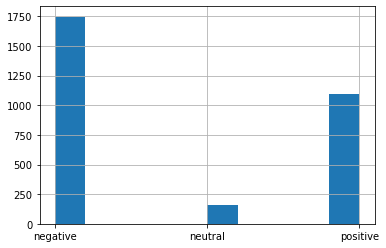

In [14]:
user_df['sentiment'].hist()

## Preprocessing

We can also prepare our data to train our models by lemmatizing the text data, which simplifies variants of similar words in our text down to its root form through linguistic mappings within the function (i.e. "running" and "ran" would become "run"). I do this to reduce the amount of data the model has to take in by further simplifiying duplicate words with different suffixes to optimize runtime.

In [15]:
lemmatizer = WordNetLemmatizer()
user_df['lemmatized'] = user_df['no_stops'].apply(lambda x:[lemmatizer.lemmatize(w) for w in x])
user_df['lemmatized']

0       [gf, started, playing, option, create, island,...
1       [great, really, relaxing, gorgeous, can't, ign...
2       [wife, looking, forward, playing, released, bo...
3       [need, equal, value, opportunity, player, isla...
4       [beware, multiple, people, house, want, play, ...
                              ...                        
2994    [island, console, limitation, cannot, play, gi...
2995    [per, giocare, con, figli, fidanzate, mogli, p...
2996    [one, island, per, console, pathetic, limitati...
2997    [even, though, seems, like, great, many, item,...
2998    [fantastic, nintendo, deciding, make, one, isl...
Name: lemmatized, Length: 2999, dtype: object

Lastly, we assign our lemmatized text data and the sentiment labels into X and y for our features and target variables and split them into training and test sets to fit our models.

In [16]:
X = user_df['lemmatized'].str.join(' ')
y = user_df['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

## Analysis

I created the `text_classification` function to streamline the fitting process of each of the machine learning algorithms we'll be using to create each model.
- The TF-IDF vectorizer is initialized to convert our text data into binary vectors that our classifiers can process.
- Because our categories are imbalanced, to prevent overfitting we oversample our data using [SMOTE](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html) and define a sampling strategy (`'not majority'`) to ensure SMOTE resamples all classes except our majority class.
- Pipelines are created to apply the vectorizer and SMOTE to our data before the model is ran on our data. This also helps prevent data leakage by ensuring that these synthetic adjustments to our data is only performed on our training set, as performing this on the test set would affect the validity of our final model. 
- We use cross-validation and recall score to evaluate the performance of our model. Cross-validation splits the training set into subsets and measures the performance of the model against each subset while the recall score helps us know how well each model is able to predict true positives among the actual positives in our data.
- A confusion matrix is also mapped to visually represent how well our model was able to correctly identify each label.

In [17]:
def text_classification(model):
    """
    Takes in a scikit-learn classifier and runs a model
    based on available training data. Returns cross-validated
    scores, an average cross-validation score, and recall score 
    rating the performance of the model. Also returns a confusion 
    matrix as a visual representation of the model's accuracy and 
    the model's pipeline. 
    """
    tfidf_vectorizer = TfidfVectorizer()
    smote = SMOTE(sampling_strategy='not majority')
    
    pipeline = make_pipeline(tfidf_vectorizer, smote, model)
    
    scores = cross_val_score(pipeline, X_train, y_train)
    print('Cross-validated scores:', scores.round(3))
    print('Average CV score:', np.mean(scores).round(3))
    
    pipeline.fit(X_train, y_train)
    y_preds = pipeline.predict(X_test)
    print('Recall score:', recall_score(y_test, y_preds, average='micro').round(3))
    
    plot_confusion_matrix(pipeline, X_test, y_test)
    
    return pipeline

First we create a machine learning model using the [logistic regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) classifier. Building off the concept of linear regression used in regression analysis, logistic regression is used in classification problems where we want to predict the labels of our features. It's simplistic in concept and function, and can be used as a starting point to compare with more complex models later on.

This model already gives a great result, as we already get a high average cross-validation score and recall score of ~82% each. Looking at the confusion matrix, it seems that it also did well in correctly distinguishing positive and negative reviews.

Cross-validated scores: [0.829 0.827 0.796 0.817 0.827]
Average CV score: 0.819
Recall score: 0.818


Text(0.5, 1.0, 'Logistic regression confusion matrix')

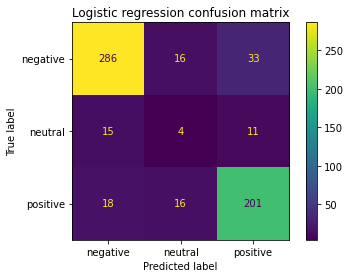

In [18]:
logreg_model = LogisticRegression(multi_class='multinomial')
logreg_pipe = text_classification(logreg_model)
plt.title('Logistic regression confusion matrix')

Our next model utilizes the [Naive Bayes](https://scikit-learn.org/stable/modules/naive_bayes.html) classifier, which extends from Bayes' theorem and assumes all our features are independent, allowing an overall probability to be obtained by multiplying the conditional probabilities of each feature. There are multiple iterations of the Naive Bayes classifier in scikit-learn, but the [multinomial Naive Bayes](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html) classifier is the most suitable for text classification due to its ability to perform classification on data with discrete features.

This model unfortunately performs worse than our first linear regression model, but still performs decently well. It still predicts true negatives well, but tends to falsely label reviews as positive or neutral more frequently.

Cross-validated scores: [0.688 0.7   0.669 0.729 0.722]
Average CV score: 0.702
Recall score: 0.695


Text(0.5, 1.0, 'Multinomial Naive Bayes confusion matrix')

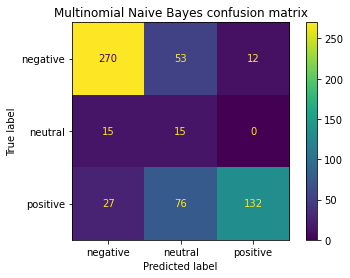

In [19]:
mnb_model = MultinomialNB()
mnb_pipe = text_classification(mnb_model)
plt.title('Multinomial Naive Bayes confusion matrix')

The next model utilizes the [decision tree](https://scikit-learn.org/stable/modules/tree.html) classifier. This is another simple classifier that revolves around the idea of predicting the value of a target variable using decision rules inferred from the data features. I think the concept of this model matches well with the idea behind our model in using key words to predict the sentiment of a review.

Unfortunately, my intuition was incorrect here -- this model performed even worse than the first two and tends to misclassify reviews as positive and negative much more often.


Cross-validated scores: [0.65  0.64  0.66  0.677 0.701]
Average CV score: 0.666
Recall score: 0.633


Text(0.5, 1.0, 'Decision tree confusion matrix')

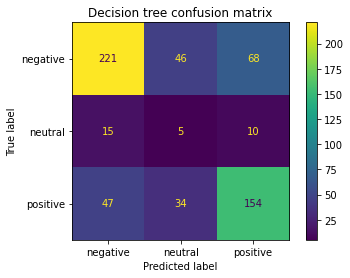

In [20]:
dt_model = DecisionTreeClassifier(max_depth=5)
dt_pipe = text_classification(dt_model)
plt.title('Decision tree confusion matrix')

Building on the decision tree model, we can also try a [random forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) classifier, which is an ensemble method derived from decision trees. Unlike the decision tree classifier, which creates a tree from the whole dataset, the random forest method takes subsets of the training set to create individual trees and averages all the trees to produce the most optimal predictive ability. 

Using the random forest classifier produced a model that did significantly better than the initial decision tree model, However, the performance of this model still falls short compared to our logistic regression model.

Cross-validated scores: [0.779 0.806 0.794 0.84  0.814]
Average CV score: 0.807
Recall score: 0.805


Text(0.5, 1.0, 'Random forest confusion matrix')

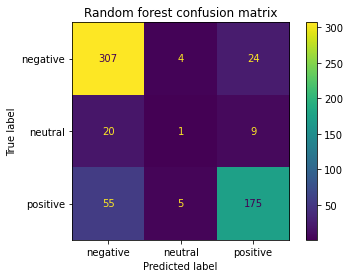

In [21]:
rf_model = RandomForestClassifier()
rf_pipe = text_classification(rf_model)
plt.title('Random forest confusion matrix')

### Optimization

Since we have obtained our best model in our logistic regression model, we can then run a grid search to find the optimal parameters for this model. In addition, I will also be performing a grid search on the random forest model; even though it is outperformed by logistic regression, I am interested in seeing if it can surpass the logistic regression model with optimized parameters.

To create the parameter grids to run the grid search on both models, I obtain the names of the parameters in each model and the values at which each parameter was at when the model was ran:

In [22]:
logreg_pipe.get_params()

{'memory': None,
 'steps': [('tfidfvectorizer', TfidfVectorizer()),
  ('smote', SMOTE(sampling_strategy='not majority')),
  ('logisticregression', LogisticRegression(multi_class='multinomial'))],
 'verbose': False,
 'tfidfvectorizer': TfidfVectorizer(),
 'smote': SMOTE(sampling_strategy='not majority'),
 'logisticregression': LogisticRegression(multi_class='multinomial'),
 'tfidfvectorizer__analyzer': 'word',
 'tfidfvectorizer__binary': False,
 'tfidfvectorizer__decode_error': 'strict',
 'tfidfvectorizer__dtype': numpy.float64,
 'tfidfvectorizer__encoding': 'utf-8',
 'tfidfvectorizer__input': 'content',
 'tfidfvectorizer__lowercase': True,
 'tfidfvectorizer__max_df': 1.0,
 'tfidfvectorizer__max_features': None,
 'tfidfvectorizer__min_df': 1,
 'tfidfvectorizer__ngram_range': (1, 1),
 'tfidfvectorizer__norm': 'l2',
 'tfidfvectorizer__preprocessor': None,
 'tfidfvectorizer__smooth_idf': True,
 'tfidfvectorizer__stop_words': None,
 'tfidfvectorizer__strip_accents': None,
 'tfidfvectorizer_

In [23]:
rf_pipe.get_params()

{'memory': None,
 'steps': [('tfidfvectorizer', TfidfVectorizer()),
  ('smote', SMOTE(sampling_strategy='not majority')),
  ('randomforestclassifier', RandomForestClassifier())],
 'verbose': False,
 'tfidfvectorizer': TfidfVectorizer(),
 'smote': SMOTE(sampling_strategy='not majority'),
 'randomforestclassifier': RandomForestClassifier(),
 'tfidfvectorizer__analyzer': 'word',
 'tfidfvectorizer__binary': False,
 'tfidfvectorizer__decode_error': 'strict',
 'tfidfvectorizer__dtype': numpy.float64,
 'tfidfvectorizer__encoding': 'utf-8',
 'tfidfvectorizer__input': 'content',
 'tfidfvectorizer__lowercase': True,
 'tfidfvectorizer__max_df': 1.0,
 'tfidfvectorizer__max_features': None,
 'tfidfvectorizer__min_df': 1,
 'tfidfvectorizer__ngram_range': (1, 1),
 'tfidfvectorizer__norm': 'l2',
 'tfidfvectorizer__preprocessor': None,
 'tfidfvectorizer__smooth_idf': True,
 'tfidfvectorizer__stop_words': None,
 'tfidfvectorizer__strip_accents': None,
 'tfidfvectorizer__sublinear_tf': False,
 'tfidfvect

Using this information, I create the parameter grids and the values I wish to test during the grid search:

In [24]:
logreg_param_grid = {
    'logisticregression__penalty': ['none', 'l2', 'l1', 'elasticnet'],
    'logisticregression__C': [0.2, 0.5, 1.0, 1.5]
}

rf_param_grid = {
    'randomforestclassifier__n_estimators': [10, 50, 100],
    'randomforestclassifier__criterion': ['gini', 'entropy']
}

We then run [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) on our pipeline models against the parameter grids we defined.

In [25]:
logreg_gridsearch = GridSearchCV(estimator=logreg_pipe,
                                param_grid=logreg_param_grid,
                                scoring='recall_micro')
logreg_gridsearch.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                                       ('smote',
                                        SMOTE(sampling_strategy='not '
                                                                'majority')),
                                       ('logisticregression',
                                        LogisticRegression(multi_class='multinomial'))]),
             param_grid={'logisticregression__C': [0.2, 0.5, 1.0, 1.5],
                         'logisticregression__penalty': ['none', 'l2', 'l1',
                                                         'elasticnet']},
             scoring='recall_micro')

 Optimizing the logistic regression model helped it perform slightly better; it has a higher recall score and as we can see from the confusion matrix, it was able to predict more true negatives than our initial model.

Best recall score: 0.845
Optimal parameters: {'logisticregression__C': 1.0, 'logisticregression__penalty': 'none'}


Text(0.5, 1.0, 'Logistic regression confusion matrix, optimized')

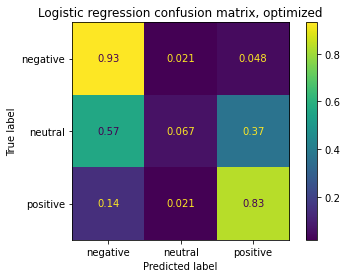

In [26]:
print("Best recall score:", logreg_gridsearch.best_score_.round(3))
print("Optimal parameters:", logreg_gridsearch.best_params_)
plot_confusion_matrix(logreg_gridsearch, X_test, y_test, normalize='true')
plt.title('Logistic regression confusion matrix, optimized')

Surprisingly, running the random forest grid search returns a very similar, if not worse result than the original random forest model -- and therefore is also worse than our logistic regression model -- with the default parameters.

In [27]:
rf_gridsearch = GridSearchCV(estimator=rf_pipe, 
                             param_grid=rf_param_grid, 
                             scoring='recall_micro')
rf_gridsearch.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                                       ('smote',
                                        SMOTE(sampling_strategy='not '
                                                                'majority')),
                                       ('randomforestclassifier',
                                        RandomForestClassifier())]),
             param_grid={'randomforestclassifier__criterion': ['gini',
                                                               'entropy'],
                         'randomforestclassifier__n_estimators': [10, 50, 100]},
             scoring='recall_micro')

Best recall score: 0.81
Optimal parameters: {'randomforestclassifier__criterion': 'entropy', 'randomforestclassifier__n_estimators': 100}


Text(0.5, 1.0, 'Random forest confusion matrix, optimized')

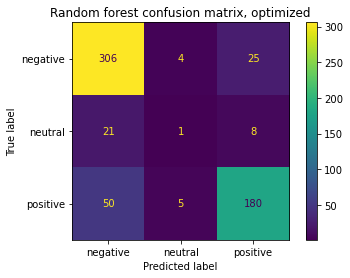

In [28]:
print("Best recall score:", rf_gridsearch.best_score_.round(3))
print("Optimal parameters:", rf_gridsearch.best_params_)
plot_confusion_matrix(rf_gridsearch, X_test, y_test)
plt.title('Random forest confusion matrix, optimized')

## Application

Now that we have our best model with optimized parameters, we can implement it into an application using Flask. If we wanted to intake newer reviews, we would have an application that would be able to rate the sentiment of a review for us without requiring a supplementary letter or number grade (for people who may be indecisive).

In preparation for exporting our model into an application, I create a new function, `text_processing`, that condenses all the steps we took to preprocess and clean our text data from earlier in this notebook. In addition to our best model, we will also need to implement this kind of function within our application so that it can perform all of these necessary steps on raw text before the model can take input in as data.

In [29]:
def text_processing(user_input):
    pattern = "([a-zA-Z]+(?:'[a-z]+)?)"
    review_text = regexp_tokenize(user_input, pattern)
    review_text = ' '.join(review_text)
    review_text = review_text.lower()

    stopwords_list = stopwords.words('english')
    stopwords_list += list(string.punctuation)
    stopwords_list += ['game', 'animal', 'crossing', 'new', 'horizons', 'horizon']
    stopwords_list += list(string.ascii_lowercase)
    review_text = [w for w in review_text.split() if w not in stopwords_list]
    
    lemmatizer = WordNetLemmatizer()
    review_text = [lemmatizer.lemmatize(w) for w in review_text]
    review_text = ' '.join(review_text)
        
    return review_text

I then recreate the pipeline with our best model and utilize the optimized parameters found in the grid search performed earlier:

In [31]:
model_X = user_df['text']
y = user_df['sentiment']

model_X  = model_X.apply(text_processing)

model = LogisticRegression(C=0.2, penalty='none')

tfidf_vectorizer = TfidfVectorizer()
smote = SMOTE(sampling_strategy='not majority')
    
pipeline = make_pipeline(tfidf_vectorizer, smote, model)
    
pipeline.fit(model_X, y)

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('smote', SMOTE(sampling_strategy='not majority')),
                ('logisticregression',
                 LogisticRegression(C=0.2, penalty='none'))])

I use the [Pickle](https://docs.python.org/3/library/pickle.html) module to then serialize the pipeline that was used to fit our optimized model and save it into a `.pkl` file.

In [43]:
file = open('acnh_review_model.pkl', 'wb')
pickle.dump(pipeline, file)
file.close()

In order to test the functionality of the pickled model before we implement it into our application, I reopen the file into the notebook and run test inputs on the model:

In [44]:
file = open('acnh_review_model.pkl', 'rb')
loaded_model = pickle.load(file)

loaded_model.predict(X)

array(['negative', 'neutral', 'negative', ..., 'negative', 'negative',
       'negative'], dtype=object)

In [45]:
# Test input #1: positive review
user_input = "I love this game so much!"
print('Input:', user_input)

cleaned_text = text_processing(user_input)
prediction = loaded_model.predict([cleaned_text])
print('Prediction:', prediction)

Input: I love this game so much!
Prediction: ['positive']


In [46]:
# Test input #2: negative review
user_input = "This game was terrible lol New Leaf was better"
print('Input:', user_input)

cleaned_text = text_processing(user_input)
prediction = loaded_model.predict([cleaned_text])
print('Prediction:', prediction)

Input: This game was terrible lol New Leaf was better
Prediction: ['negative']


It looks like both test inputs were predicted accurately, so this model is ready to be implemented into an external application! I use [Flask](https://flask.palletsprojects.com/en/2.0.x/) to create a web application for our model and deploy it using Heroku to make it an accessible webpage to all users. The application can be found here: [Animal Crossing: New Horizons Sentiment Rater](https://acnh-sentiment-rater.herokuapp.com/).

## Conclusion

We were able to obtain a machine learning model that was able to accurately predict sentiment labels of our review data; it was able to predict these labels with an ~82% recall score, which increased to ~84% with optimized parameters. With this model, we were also able to create an application with which we can rate new user-submitted reviews. This way, we can track the overall player sentiment surrounding Animal Crossing: New Horizons after the date range in our data and keeping it current during this game's update lifespan.

### Next Steps

Given more time, the next steps I would like to take with this project primarily lie within updating the application with additional features. These are some of the ideas I had in mind:
- Implementing a database within the application that can archive reviews and their sentiment rating. This would help immensely with keeping track of overall sentiment and individual reviews.
- Enabling users to see statistics on the front end after submitting a review, such as how many other users agreed with them among other app users and users who submitted reviews on other websites like Metacritic.
- Expanding the application to contain a database of Switch games that includes details about each game such as trailers, reviews from other sites, etc., allowing for a wider application among more Switch games.
- Implementing a recommender system where users can be recommended games based on whether they liked the game they submit a review for (i.e. if a user gave a negative review for New Horizons they would receive recommendations based on what was popular among other people who also gave negative reviews). The recommender system would also allow for users to be recommended games based on genre.
- Multilingual support. At the moment, the app can only accurately predict the sentiment of English reviews, but as there were also reviews in different languages in our initial dataset (that were already labeled), I would like for my app to be able to take in reviews from a wider variety of consumers who may not speak English.